In [13]:
import torch
import numpy as np
from Bio import SeqIO
from transformers import AutoTokenizer, EsmForMaskedLM
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from latentmi import lmi
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from lmfit import Model

In [17]:
fn = '../DistributionEmbeddings/data/spikeprot0430/spikeprot0430.fasta'
ratios = np.logspace(-3, 6, 5)
noise_levels = 1 / (ratios+1)
print(noise_levels)
aas = list("ACDEFGHIKLMNPQRSTVWY")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def parse_data(path, frac_to_read=0.01, lines_to_read=10**8):
#     seqs, months = [], []
#     iterator = SeqIO.parse(path, "fasta")
#     for _ in tqdm(range(lines_to_read)):
#         if np.random.rand() > frac_to_read:
#             continue
#         try:
#             r = next(iterator)
#             fields = r.description.split("|")
#             date = (fields + ["?"] * 11)[2]
            
#             # filter valid dates
#             if len(date) == 10 and date[4] == '-' and '00' not in date:
#                 seqs.append(str(r.seq))
#                 yyyy_mm = date[:7]
#                 months_since_2020 = (int(yyyy_mm[:4]) - 2020) * 12 + int(yyyy_mm[5:7]) - 1
#                 months.append(months_since_2020)
#         except:
#             continue
#     return seqs, np.array(months).reshape(-1, 1)

def parse_data(path, lines_to_read=10**8, max_per_month=100):
    """parse data with balanced sampling across months."""
    seqs_by_month = defaultdict(list)
    iterator = SeqIO.parse(path, "fasta")
    
    for _ in tqdm(range(lines_to_read), desc='collecting sequences'):
        try:
            r = next(iterator)
            fields = r.description.split("|")
            date = (fields + ["?"] * 11)[2]
            
            # filter valid dates
            if len(date) == 10 and date[4] == '-' and date[5:7] != '00' and date[-2:] != '00':
                yyyy_mm = date[:7]
                months_since_2020 = (int(yyyy_mm[:4]) - 2020) * 12 + int(yyyy_mm[5:7]) - 1
                
                # Only add if we haven't hit the cap for this month
                if len(seqs_by_month[months_since_2020]) < max_per_month:
                    seqs_by_month[months_since_2020].append(str(r.seq))
        except StopIteration:
            break
        except:
            continue
    
    # Flatten to lists
    seqs, months = [], []
    for month_val, month_seqs in seqs_by_month.items():
        seqs.extend(month_seqs)
        months.extend([month_val] * len(month_seqs))
    
    print(f"Collected {len(seqs)} sequences across {len(seqs_by_month)} unique months")
    print(f"Months: {sorted(seqs_by_month.keys())}")
    
    return seqs, np.array(months).reshape(-1, 1)

def mutate(seq_list, rate):
    # randomize aa based on rate
    noised = []
    for s in tqdm(seq_list, desc='mutating', leave=False):
        s_arr = np.array(list(s))
        mask = np.random.rand(len(s_arr)) < rate
        s_arr[mask] = np.random.choice(aas, size=mask.sum())
        noised.append("".join(s_arr))
    return noised

class VirusDS(Dataset):
    def __init__(self, seqs, enc):
        self.enc = enc(seqs, return_tensors="pt", padding=True, truncation=True, max_length=1024)
    def __len__(self): return len(self.enc['input_ids'])
    def __getitem__(self, i): return {k: v[i] for k, v in self.enc.items()}

[9.99000999e-01 8.49020443e-01 3.06534300e-02 1.77796324e-04
 9.99999000e-07]


In [15]:
all_seqs, all_months = parse_data(fn, lines_to_read=10**8, max_per_month=1000)

collecting sequences:   0%|          | 0/100000000 [00:00<?, ?it/s]

Collected 63374 sequences across 71 unique months
Months: [-109, -78, -29, -10, -7, -3, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [16]:
tr_seqs, te_seqs, _, te_months = train_test_split(all_seqs, all_months, test_size=0.25)

print(f"loaded {len(all_seqs)} seqs :)")

print('unique months in test set:', np.unique(te_months))

results = {}

loaded 63374 seqs :)
unique months in test set: [-7 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [ ]:
# which models do we want to look at?
model_configs = [
    {"name": "8M", "model_id": "facebook/esm2_t6_8M_UR50D"},
    {"name": "35M", "model_id": "facebook/esm2_t12_35M_UR50D"}
]

# shared tok
tok = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

# Store results with model size
results = []

for nl in tqdm(noise_levels, desc=f"Noise levels"):
    print(f"\n{'='*60}")
    print(f"Processing noise level: {nl}")
    print(f"{'='*60}\n")
    
    # noising_process - do this once per noise level
    tr_n = mutate(tr_seqs, nl)
    te_n = mutate(te_seqs, nl)
    
    # tokenize once per noise level
    train_loader = DataLoader(VirusDS(tr_n, tok), batch_size=8, shuffle=True)
    
    # now train each model with the same tokenized data
    for model_config in model_configs:
        model_name = model_config["name"]
        model_id = model_config["model_id"]
        
        print(f"\n--- Training {model_name} model ---")
        
        # init model
        net = EsmForMaskedLM.from_pretrained(model_id).to(device)
        
        # finetune
        optim = AdamW(net.parameters(), lr=1e-4)
        
        print('training')
        net.train()
        for i, batch in enumerate(train_loader):
            inp = batch['input_ids'].to(device)
            lbl = inp.clone()
            # mask 15% for training
            rand = torch.rand(inp.shape).to(device)
            msk = (rand < 0.15) & (inp != tok.cls_token_id) & (inp != tok.pad_token_id)
            inp[msk] = tok.mask_token_id
            
            loss = net(input_ids=inp, attention_mask=batch['attention_mask'].to(device), labels=lbl).loss
            loss.backward()
            optim.step()
            optim.zero_grad()
        
        # save model
        model_path = f"seq/model_{model_name}_noise_{nl:.6f}.pt"
        torch.save(net.state_dict(), model_path)
        print(f"saved model to {model_path}")
            
        print("extracting embeddings...")
        net.eval()
        feats = []
        # minimal batching for eval - tokenize test data once and reuse
        with torch.no_grad():
            # process in chunks to save mem
            for i in range(0, len(te_n), 16):
                batch = te_n[i:i+16]
                inputs = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
                # use mean pooling of last hidden state
                out = net.base_model(**inputs).last_hidden_state
                # mask out padding tokens for accurate mean
                mask = inputs.attention_mask.unsqueeze(-1).expand(out.size()).float()
                sum_embeddings = torch.sum(out * mask, 1)
                sum_mask = torch.clamp(mask.sum(1), min=1e-9)
                feats.append((sum_embeddings / sum_mask).cpu().numpy())

        X = np.vstack(feats)
        
        print("estimating mi...")
        pointwise, _, _ = lmi.estimate(X, te_months)
        avg_mi = np.nanmean(pointwise)
        
        results.append({
            'model_size': model_name,
            'noise_level': nl,
            'mutual_information': avg_mi
        })
        print(f"model: {model_name}, noise: {nl} -> mi: {avg_mi:.4f}")
        
        # clean up gpu
        del net
        torch.cuda.empty_cache()

print("\ndone! converting to dataframe...")
res_df = pd.DataFrame(results)
res_df = res_df[res_df['noise_level'] <= 1]
res_df['true/error'] = (1 - res_df['noise_level'])/res_df['noise_level']
res_df.to_csv('seq/multisize_gisaid_results.csv', index=False)
print("saved to seq/multisize_gisaid_results.csv")
print(res_df)

Noise levels:   0%|          | 0/5 [00:00<?, ?it/s]


Processing noise level: 0.9990009990009991



mutating:   0%|          | 0/47530 [00:00<?, ?it/s]

mutating:   0%|          | 0/15844 [00:00<?, ?it/s]


--- Training 8M model ---
training
saved model to seq/model_8M_noise_0.999001.pt
extracting embeddings...
estimating mi...
epoch 52 (of max 300) 🌻model: 8M, noise: 0.9990009990009991 -> mi: -0.0004

--- Training 35M model ---


config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

training
saved model to seq/model_35M_noise_0.999001.pt
extracting embeddings...
estimating mi...
epoch 51 (of max 300) 🌻model: 35M, noise: 0.9990009990009991 -> mi: 0.0044

Processing noise level: 0.8490204427886767



mutating:   0%|          | 0/47530 [00:00<?, ?it/s]

mutating:   0%|          | 0/15844 [00:00<?, ?it/s]


--- Training 8M model ---
training
saved model to seq/model_8M_noise_0.849020.pt
extracting embeddings...
estimating mi...
epoch 53 (of max 300) 🌻model: 8M, noise: 0.8490204427886767 -> mi: 0.1321

--- Training 35M model ---
training
saved model to seq/model_35M_noise_0.849020.pt
extracting embeddings...
estimating mi...
epoch 47 (of max 300) 🌻model: 35M, noise: 0.8490204427886767 -> mi: 0.1385

Processing noise level: 0.030653430031715508



mutating:   0%|          | 0/47530 [00:00<?, ?it/s]

mutating:   0%|          | 0/15844 [00:00<?, ?it/s]


--- Training 8M model ---
training
saved model to seq/model_8M_noise_0.030653.pt
extracting embeddings...
estimating mi...
epoch 280 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻model: 8M, noise: 0.030653430031715508 -> mi: 2.3058

--- Training 35M model ---
training
saved model to seq/model_35M_noise_0.030653.pt
extracting embeddings...
estimating mi...
epoch 269 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻model: 35M, noise: 0.030653430031715508 -> mi: 2.1164

Processing noise level: 0.00017779632384970406



mutating:   0%|          | 0/47530 [00:00<?, ?it/s]

mutating:   0%|          | 0/15844 [00:00<?, ?it/s]


--- Training 8M model ---
training
saved model to seq/model_8M_noise_0.000178.pt
extracting embeddings...
estimating mi...
epoch 297 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻model: 8M, noise: 0.00017779632384970406 -> mi: 2.8965

--- Training 35M model ---
training
saved model to seq/model_35M_noise_0.000178.pt
extracting embeddings...
estimating mi...
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻model: 35M, noise: 0.00017779632384970406 -> mi: 2.9640

Processing noise level: 9.99999000001e-07



mutating:   0%|          | 0/47530 [00:00<?, ?it/s]

mutating:   0%|          | 0/15844 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/orcd/home/002/gokulg/miniforge3/envs/scaling/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3289284/2306419153.py", line 23, in <module>
    train_loader = DataLoader(VirusDS(tr_n, tok), batch_size=8, shuffle=True)
                              ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_3289284/2718553866.py", line 76, in __init__
    self.enc = enc(seqs, return_tensors="pt", padding=True, truncation=True, max_length=1024)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/orcd/home/002/gokulg/miniforge3/envs/scaling/lib/python3.11/site-packages/transformers/tokenization_utils_base.py", line 2938, in __call__
    encodings = self._call_one(text=text, text_pair=text_pair, **all_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/orcd/hom

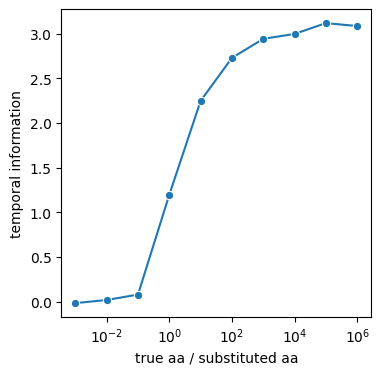

In [7]:
plt.figure(figsize=(4,4))
sns.lineplot(data=res_df, x='true/error', y='mutual_information', marker='o')
plt.xscale('log')
plt.ylabel('temporal information')
plt.xlabel('true aa / substituted aa')
plt.show()

In [2]:
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))


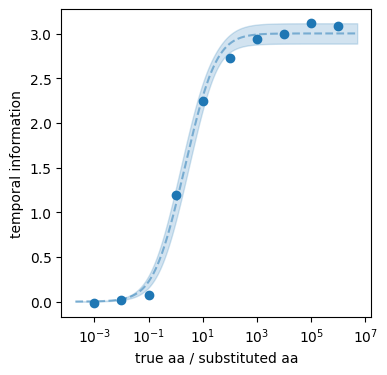

In [3]:
res_df = pd.read_csv('seq/gisaid_results.csv')

x_data = res_df['true/error']
y_data = res_df['mutual_information']

palette = sns.color_palette("tab10", n_colors=10)

# create model and parameters
model = Model(info_scaling)
params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
params['A'].min = 0  # set bounds
params['B'].min = 0

# fit model
result = model.fit(y_data, params, x=x_data)

# generate fit line
x_fit = np.logspace(np.log10(x_data.min()/5), np.log10(5*x_data.max()), 10**5)
y_fit = model.eval(params=result.params, x=x_fit)

# calculate confidence bands
y_upper = result.eval_uncertainty(params=result.params, 
                                    x=x_fit, sigma=2)
y_lower = -y_upper


plt.figure(figsize=(4,4))
# plot fit and data
plt.plot(x_fit, y_fit, linestyle='--', color=palette[0], alpha=0.5)
plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[0], alpha=0.2)
plt.scatter(x_data, y_data, color=palette[0], label='Data')

plt.xscale('log')
plt.ylabel('temporal information')
plt.xlabel('true aa / substituted aa')
plt.show()

In [12]:
x_bar = 1/result.params['A'].value
I_max = 0.5*np.log2(result.params['B'].value/result.params['A'].value)

def uq(ubar, Imax, q=0.90):
    I = Imax + np.log2(q)
    return ubar*((2**(2*I)- 1)/(2**(2*Imax) - 2**(2*I)))

x_90 = uq(x_bar, I_max, q=0.90)


print("x bar: ", x_bar)
print("I max: ", I_max)
print("x 90%: ", x_90)

x bar:  17.465611843659527
I max:  3.0028307092323483
x 90%:  73.02796959840377
